In [13]:

import gempy as gp
import gempy_viewer as gpv
from gempy.core.data import GeoModel
from gempy.core.data import Grid
from gempy.core.data.grid_modules import RegularGrid
from gempy_engine.core.data.stack_relation_type import StackRelationType


import pickle
import rasterio
from scipy.interpolate import LinearNDInterpolator


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, time
import pyvista as pv


import torch.nn.functional as F
from scipy.ndimage import median_filter


np.random.seed(55500)

In [2]:
nx, ny, nz = 50,50,50  # match the later reshaping/processing
geo_model: gp.data.GeoModel = gp.create_geomodel(
    project_name='Model1',
    extent=[4729200, 4742900,
            2047800, 2060550,
            -3500, 5500],  # x, y, z
    resolution=[nx, ny, nz],
    refinement=4,  # we will use octrees
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations=os.path.join(os.getcwd(), "Orientations.csv"),
        path_to_surface_points=os.path.join(os.getcwd(), "Points.csv"),
    )
)


In [3]:
gp.map_stack_to_surfaces(
    gempy_model=geo_model,
    mapping_object=  # TODO: This mapping I do not like it too much. We should be able to do it passing the data objects directly
    {
        "Strat_Series1": ('R1_1'),     
        "Strat_Series2": ('C2'),
        "Strat_Series3": ('C1'),
        "Strat_Series4": ('C4b'),
        "Strat_Series5": ('R2'),
        "Strat_Series6": ('R1'),
        "Strat_Series7": ('R2_1'),
        "Strat_Series8": ('C4'),
    }
)
geo_model.structural_frame  # Display the resulting structural frame


StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Strat_Series1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=R1_1,
	color=#ff3f20,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series2,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=C2,
	color=#9f0052,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series3,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=C1,
	color=#015482,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series4,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=C4b,
	color=#728f02,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series5,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=R2,
	color=#5DA629,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series6,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=R1,
	color=#443988,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series7,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=R2_1,
	color=#b271d0,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series8,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=C4,
	color=#ffbe00,
	is_active=True
)
]
)
],
	fault_relations=
[[False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False],
 [False, False, False, False, False, False, False, False]],

c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\gempy_viewer\API\_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


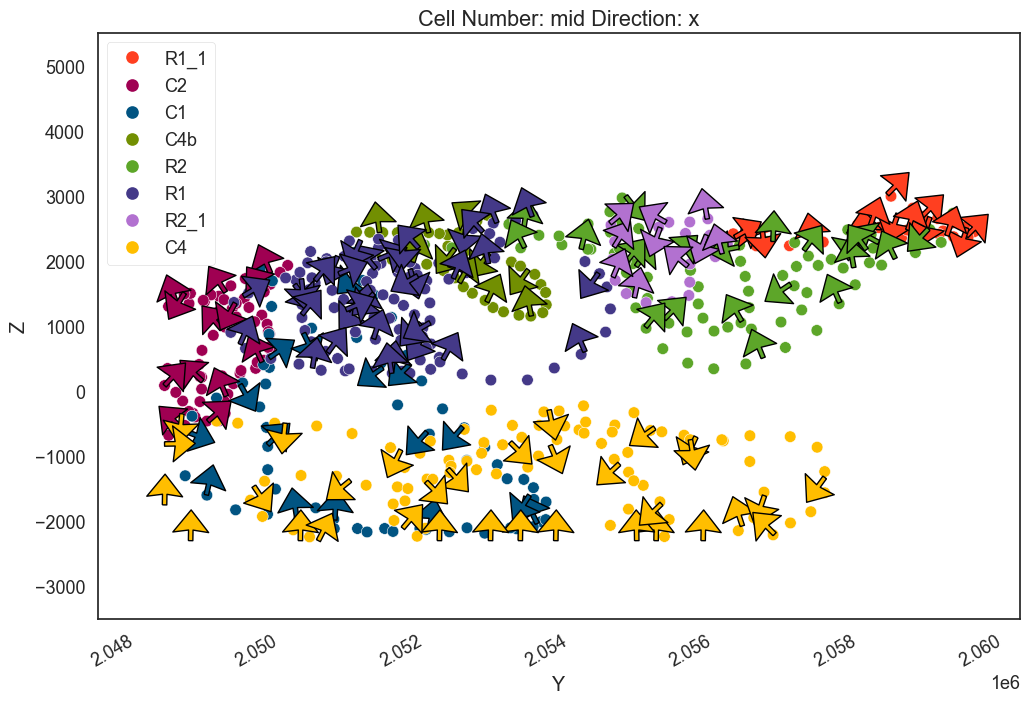

In [4]:
plot = gpv.plot_2d(geo_model, show_lith=False, show_boundaries=False, direction='x')

In [5]:
geotiff_path = os.path.join("dem.tif")

In [6]:
with rasterio.open(geotiff_path) as src:
        band = src.read(1)
        transform = src.transform


        rows, cols = np.meshgrid(
            np.arange(band.shape[0]), np.arange(band.shape[1]), indexing='ij'
        )


        xs, ys = rasterio.transform.xy(transform, rows, cols)
        xs = np.array(xs)
        ys = np.array(ys)


        xs = xs.reshape(-1,1)
        ys = ys.reshape(-1,1)
        zs = band.reshape(-1,1)

# Flatten the data into (N,3) shape
topography_points = np.vstack((xs.ravel(), ys.ravel(), zs.ravel())).T

In [7]:
gp.set_topography_from_arrays(grid=geo_model.grid, xyz_vertices=topography_points)

Active grids: GridTypes.NONE|TOPOGRAPHY|DENSE


In [8]:
geo_model.input_transform.apply_anisotropy(gp.data.GlobalAnisotropy.NONE)
geo_model.interpolation_options.kernel_options.range *= 2.4


gp.compute_model(
    gempy_model=geo_model,
    engine_config=gp.data.GemPyEngineConfig(
        backend=gp.data.AvailableBackends.PYTORCH
    )
)

Setting Backend To: AvailableBackends.PYTORCH
Chunking done: 19 chunks
Chunking done: 27 chunks
Chunking done: 29 chunks
Chunking done: 18 chunks
Chunking done: 42 chunks
Chunking done: 56 chunks
Chunking done: 13 chunks
Chunking done: 51 chunks
Chunking done: 7 chunks
Chunking done: 8 chunks
Chunking done: 11 chunks
Chunking done: 15 chunks
Chunking done: 14 chunks


Solutions(4 Octree Levels, 8 DualContouringMeshes)

In [27]:
gpv.plot_3d(model=geo_model,
            plotter_type='basic',
            show_surfaces=True,
            show_topography=True,
            show_data=True,
            show_lith=False,
            legend=True,
            )

c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\gempy_viewer\API\_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


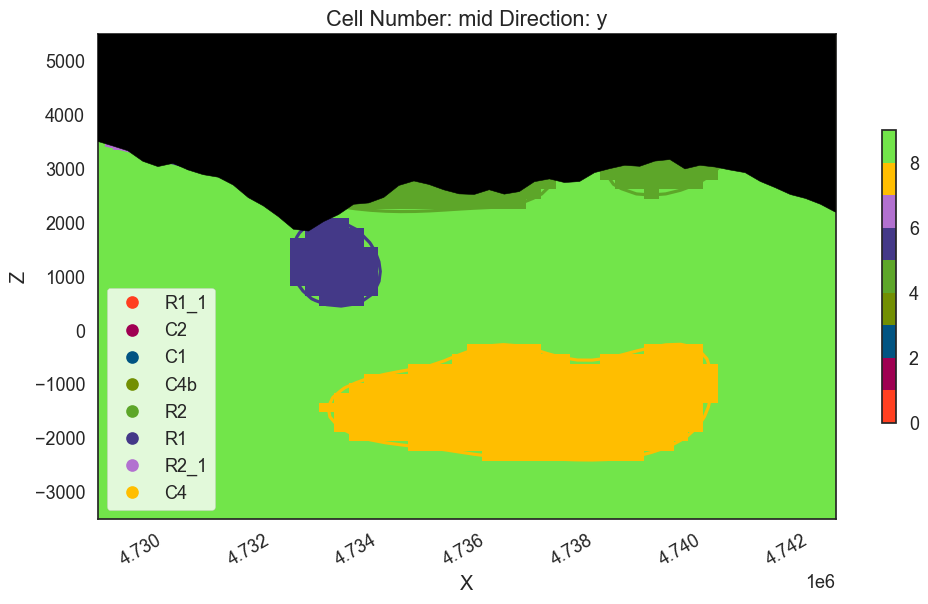

In [10]:
gpv.plot_2d(
    model=geo_model, show_topography=True, show_data=False,
)

In [21]:
vals = geo_model.grid.regular_grid.values  # (nC, 3) en el mismo orden que lith_block
lith_flat = geo_model.solutions.raw_arrays.lith_block  # (nC,)

x_vec = np.unique(vals[:, 0])
y_vec = np.unique(vals[:, 1])
z_vec = np.unique(vals[:, 2])

nx, ny, nz = len(x_vec), len(y_vec), len(z_vec)

ix = np.searchsorted(x_vec, vals[:, 0])
iy = np.searchsorted(y_vec, vals[:, 1])
iz = np.searchsorted(z_vec, vals[:, 2])

lith_3d = np.empty((nx, ny, nz), dtype=lith_flat.dtype)
lith_3d[ix, iy, iz] = lith_flat   # <-- ahora SÍ queda (nx, ny, nz)

print("lith_3d:", lith_3d.shape)  # (nx, ny, nz)


lith_3d: (50, 50, 50)


In [22]:
# crear malla XY de la grilla
XX, YY = np.meshgrid(x_vec, y_vec, indexing="ij")  # (nx, ny)

# samplear el dem en esos puntos
with rasterio.open("dem.tif") as src:
    coords = np.c_[XX.ravel(), YY.ravel()]
    topo = np.array([v[0] for v in src.sample(coords)], dtype=float).reshape(nx, ny)

topo_z = topo  # (nx, ny)
print("topo_z:", topo_z.shape)

topo_z: (50, 50)


In [23]:
mask_air = z_vec[None, None, :] > topo_z[:, :, None]   # (nx, ny, nz)

model_active = lith_3d.astype(float)
model_active[mask_air] = np.nan


model_active = median_filter(model_active, size=2)

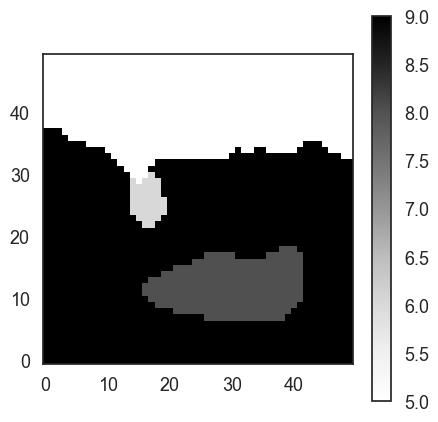

In [24]:
fig = plt.figure(figsize=(5,5))
plt.imshow(model_active[:,ny//2,:].T,origin='lower')
plt.colorbar()

In [25]:
print(model_active.shape)

(50, 50, 50)


In [26]:
np.save('ModelB.npy', model_active)

print(f"Dimensiones del modelo 3D: {model_active.shape}")

Dimensiones del modelo 3D: (50, 50, 50)
